In [2]:
from typing import Set
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from pylogics.parsers import parse_ltl
import pylogics.parsers.ldl
import logaut

from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from stochastic_service_composition.declare_utils import *
from stochastic_service_composition.dfa_target import from_symbolic_automaton_to_declare_automaton
from stochastic_service_composition.dfa_target import mdp_from_dfa
from docs.notebooks.utils import render_service, render_target, render_composition_mdp, render_mdp_dfa, \
    print_policy_data, print_value_function, print_q_value_function, render_comp_mdp
from stochastic_service_composition.composition_mdp import composition_mdp, comp_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions, target_from_dfa


## Use case for "Stochastic Service Composition with Industrial APIs" - Chip Production.

In this notebook, we present the implementation of the use case for "Stochastic Service Composition with Industrial APIs" about chip production.

# Available Services

In the following we provide definitions about available services:

In [3]:
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB
BROKEN_PROB = 0.5
HIGH_BROKEN_PROB = 0.7

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB
HIGH_UNEMPLOYABLE_PROB = 0.5

# costs of the machines that perform their job in different countries
DEFAULT_USA_REWARD = -1.0
WAR_REWARD = -3.0
USA_REWARD = -2.0
HIGH_USA_REWARD = -5.0
UK_REWARD = -6.8
CHINA_REWARD = -11.7
TAIWAN_REWARD = -12.2
RUSSIA_REWARD = -9.12 # we have to take into the account political problems
NORWAY_REWARD = -7.16
BRAZIL_REWARD = -6.7
FRANCE_REWARD = -7.6
MALAYSIA_REWARD = -14.73
TURKEY_REWARD = -10.16
KAZAKHSTAN_REWARD = -10.4
CHILE_REWARD = -7.8
BOLIVIA_REWARD = -6.8
ARGENTINA_REWARD = -8.55
MOROCCO_REWARD = -7.9
JAPAN_REWARD = -10.1
SOUTH_KOREA = -10.7
NETHERLANDS_REWARD = -7.5
#ISRAEL_REWARD = -10.81 # we have to take into the account political/religious problems

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -10.0

In [47]:
# all the atomic actions for the task
PICK_BUY_DESIGN = "pick_buy_design"
PICK_SILICON = "pick_silicon"
PICK_WAFER = "pick_wafer"
PICK_BORON = "pick_boron"
PICK_PHOSPHOR = "pick_phosphor"
CLEANING = "cleaning"
FILM_DEPOSITION = "film_deposition"
RESIST_COATING = "resist_coating"
EXPOSURE = "exposure"
DEVELOPMENT = "development"
ETCHING = "etching"
IMPURITIES_IMPLANTATION = "impurities_implantation"
ACTIVATION = "activation"
RESIST_STRIPPING = "resist_stripping"
ASSEMBLY = "assembly"
TESTING ="testing"
PACKAGING = "packaging"

SYMBOLS_PHASE_1 = [
    PICK_BUY_DESIGN,
    PICK_SILICON,
    PICK_WAFER,
    PICK_BORON,
    PICK_PHOSPHOR
]

SYMBOLS_PHASE_2 = [
    CLEANING,
    FILM_DEPOSITION,
    RESIST_COATING,
    EXPOSURE,
    DEVELOPMENT,
    ETCHING,
    IMPURITIES_IMPLANTATION,
    ACTIVATION,
    RESIST_STRIPPING,
    ASSEMBLY,
    TESTING,
    PACKAGING
]

In [5]:
# service names
DESIGN_SERVICE_NAME_USA = "design_usa"                                      # human
DESIGN_SERVICE_NAME_UK = "design_uk"                                        # human
DESIGN_SERVICE_NAME_CHINA = "design_china"                                  # human
DESIGN_SERVICE_NAME_TAIWAN = "design_taiwan"                                # human
SILICON_WAREHOUSE_SERVICE_NAME = "silicon_warehouse"                        # warehouse
WAFER_WAREHOUSE_SERVICE_NAME = "wafer_warehouse"                            # warehouse
BORON_WAREHOUSE_SERVICE_NAME = "boron_warehouse"                            # warehouse
PHOSPHOR_WAREHOUSE_SERVICE_NAME = "phosphor_warehouse"                      # warehouse
SILICON_SERVICE_NAME_CHINA = "silicon_china"                                # human
SILICON_SERVICE_NAME_RUSSIA = "silicon_russia"                              # human
SILICON_SERVICE_NAME_NORWAY = "silicon_norway"                              # human
SILICON_SERVICE_NAME_USA = "silicon_usa"                                    # human
SILICON_SERVICE_NAME_FRANCE = "silicon_france"                              # human
SILICON_SERVICE_NAME_BRAZIL = "silicon_brazil"                              # human
SILICON_SERVICE_NAME_MALAYSIA = "silicon_malaysia"                          # human
WAFER_SERVICE_NAME_JAPAN = "wafer_japan"                                    # human
WAFER_SERVICE_NAME_SOUTH_KOREA = "wafer_south_korea"                        # human
BORON_SERVICE_NAME_TURKEY = "boron_turkey"                                  # human
BORON_SERVICE_NAME_USA = "boron_usa"                                        # human
BORON_SERVICE_NAME_KAZAKHSTAN = "boron_kazakhstan"                          # human
BORON_SERVICE_NAME_CHILE = "boron_chile"                                    # human
BORON_SERVICE_NAME_CHINA = "boron_china"                                    # human
BORON_SERVICE_NAME_ARGENTINA = "boron_argentina"                            # human
BORON_SERVICE_NAME_RUSSIA = "boron_russia"                                  # human
BORON_SERVICE_NAME_BOLIVIA = "boron_bolivia"                                # human
PHOSPHOR_SERVICE_NAME_MOROCCO = "phosphor_morocco"                          # human
PHOSPHOR_SERVICE_NAME_CHINA = "phosphor_china"                              # human
PHOSPHOR_SERVICE_NAME_USA = "phosphor_usa"                                  # human
CLEANING_HUMAN_SERVICE_NAME = "cleaning_human"                              # human
CLEANING_SERVICE_NAME = "cleaning_machine"                                  # machine
FILM_DEPOSITION1_SERVICE_NAME = "film_deposition_machine1"                  # machine
FILM_DEPOSITION2_SERVICE_NAME = "film_deposition_machine2"                  # machine
RESIST_COATING1_SERVICE_NAME = "resist_coating_machine1"                    # machine
RESIST_COATING2_SERVICE_NAME = "resist_coating_machine2"                    # machine
EXPOSURE_HUMAN_SERVICE_NAME = "exposure_human"                              # human
EXPOSURE_SERVICE_NAME = "exposure_machine"                                  # machine
DEVELOPMENT1_SERVICE_NAME = "development1_machine"                          # machine
DEVELOPMENT2_SERVICE_NAME = "development2_machine"                          # machine
ETCHING1_SERVICE_NAME = "etching1_machine"                                  # machine
ETCHING2_SERVICE_NAME = "etching2_machine"                                  # machine
IMPURITIES_IMPLANTATION1_SERVICE_NAME = "impurities_implantation1_machine"  # machine
IMPURITIES_IMPLANTATION2_SERVICE_NAME = "impurities_implantation2_machine"  # machine
ACTIVATION_HUMAN_SERVICE_NAME = "activation_human"                          # human
ACTIVATION_SERVICE_NAME = "activation_machine"                              # machine
RESIST_STRIPPING1_SERVICE_NAME = "resist_stripping1_machine"                # machine
RESIST_STRIPPING2_SERVICE_NAME = "resist_stripping2_machine"                # machine
ASSEMBLY_HUMAN_SERVICE_NAME = "assembly_human"                              # human
ASSEMBLY_SERVICE_NAME = "assembly_machine"                                  # machine
TESTING_HUMAN_SERVICE_NAME = "testing_human"                                # human
TESTING_SERVICE_NAME = "testing_machine"                                    # machine
PACKAGING_HUMAN_SERVICE_NAME = "packaging_human"                            # human
PACKAGING_SERVICE_NAME = "packaging_machine"                                # human

We have different type of services:

- generic breakable machines;
- complex breakable machines;
- warehouse machines;
- human workers

In [6]:
def build_generic_breakable_service(service_name: str, action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    success_prob = deterministic_prob - broken_prob
    transitions = {
        "available": {
          action_name: ({"done": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            f"check_{action_name}": ({"available": 1.0}, broken_reward),
        },
        "done": {
            f"check_{action_name}": ({"available": 1.0}, 0.0),
        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_complex_breakable_service(service_name: str, action_name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    configure_success_prob = deterministic_prob - unemployable_prob
    op_success_prob = deterministic_prob - broken_prob
    transitions = {
        "ready": { # current state
            f"CONFIG[{action_name}]": # action
                (
                    {
                        "configured": deterministic_prob # next state : prob
                    },
                    0.0
                ),
        },
        "configured": {
            f"CHECKED[{action_name}]":
                (
                    {
                    "executing": configure_success_prob,
                    "broken": unemployable_prob
                    } if unemployable_prob > 0.0 else {"executing": configure_success_prob},
                    0.0
                ),
        },
        "executing": {
            action_name: # operation
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    } if broken_prob > 0.0 else {"ready": op_success_prob},
                    action_reward
                ),
        },
        "broken": {
            f"RESTORE[{action_name}]":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   broken_reward
               ),
        },
        "repairing": {
            f"REPAIRED[{action_name}]":
                (
                    {
                        "ready": deterministic_prob
                    },
                    0.0
                ),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    action_reward: float,
) -> Service:
    """Build the one state device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, action_reward) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

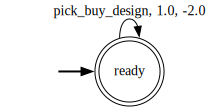

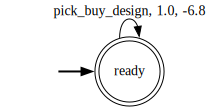

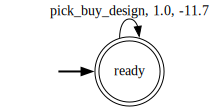

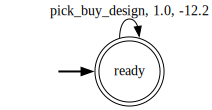

In [7]:
def design_service(name: str, action_reward: float) -> Service:
    """Build the design device."""
    return build_generic_service_one_state(
        name,
        {PICK_BUY_DESIGN},
        action_reward=action_reward
    )

service_design_usa = design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD)
service_design_uk = design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD)
service_design_china = design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD)
service_design_taiwan = design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD)
render_service(service_design_usa)
render_service(service_design_uk)
render_service(service_design_china)
render_service(service_design_taiwan)

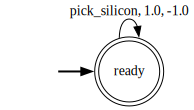

In [8]:
def silicon_warehouse_service(name: str = SILICON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the silicon warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_warehouse = silicon_warehouse_service()
render_service(service_silicon_warehouse)

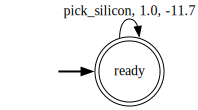

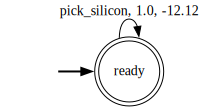

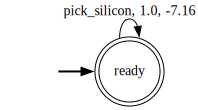

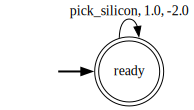

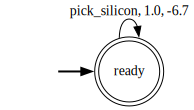

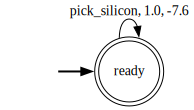

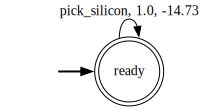

In [9]:
def silicon_service(name: str, action_reward) -> Service:
    """Build the silicon device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_china = silicon_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_silicon_russia = silicon_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
service_silicon_norway = silicon_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD)
service_silicon_usa = silicon_service(SILICON_SERVICE_NAME_USA, USA_REWARD)
service_silicon_brazil = silicon_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD)
service_silicon_france = silicon_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD)
service_silicon_malaysia = silicon_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD)
render_service(service_silicon_china)
render_service(service_silicon_russia)
render_service(service_silicon_norway)
render_service(service_silicon_usa)
render_service(service_silicon_brazil)
render_service(service_silicon_france)
render_service(service_silicon_malaysia)

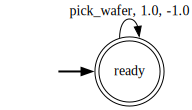

In [10]:
def wafer_warehouse_service(name: str = WAFER_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the wafer warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_warehouse = wafer_warehouse_service()
render_service(service_wafer_warehouse)

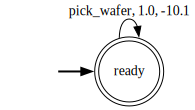

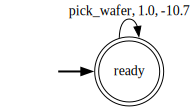

In [11]:
def wafer_service(name: str, action_reward: float) -> Service:
    """Build the wafer device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_japan = wafer_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD)
service_wafer_south_korea = wafer_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA)
render_service(service_wafer_japan)
render_service(service_wafer_south_korea)

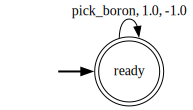

In [12]:
def boron_warehouse_service(name: str = BORON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the boron warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_warehouse = boron_warehouse_service()
render_service(service_boron_warehouse)

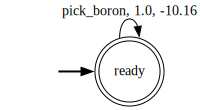

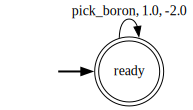

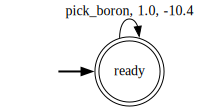

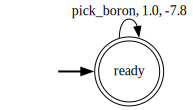

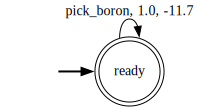

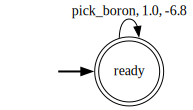

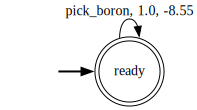

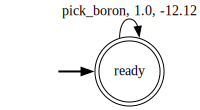

In [13]:
def boron_service(name: str, action_reward: float) -> Service:
    """Build the boron device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_turkey = boron_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD)
service_boron_usa = boron_service(BORON_SERVICE_NAME_USA, USA_REWARD)
service_boron_kazakhstan = boron_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD)
service_boron_chile = boron_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD)
service_boron_china = boron_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_boron_bolivia = boron_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD)
service_boron_argentina = boron_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD)
service_boron_russia = boron_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
render_service(service_boron_turkey)
render_service(service_boron_usa)
render_service(service_boron_kazakhstan)
render_service(service_boron_chile)
render_service(service_boron_china)
render_service(service_boron_bolivia)
render_service(service_boron_argentina)
render_service(service_boron_russia)

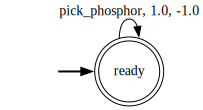

In [14]:
def phosphor_warehouse_service(name: str = PHOSPHOR_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the phosphor warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_warehouse = phosphor_warehouse_service()
render_service(service_phosphor_warehouse)

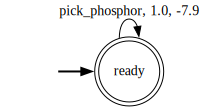

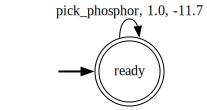

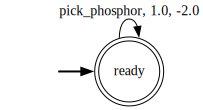

In [15]:
def phosphor_service(name: str, action_reward: float) -> Service:
    """Build the phosphor device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_morocco = phosphor_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD)
service_phosphor_china = phosphor_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD)
service_phosphor_usa = phosphor_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD)
render_service(service_phosphor_morocco)
render_service(service_phosphor_china)
render_service(service_phosphor_usa)

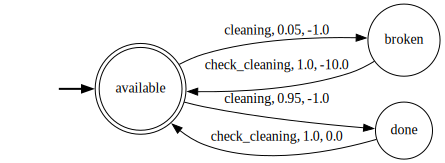

In [16]:
def cleaning_service(name: str = CLEANING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the cleaning device."""
    return build_generic_breakable_service(name, CLEANING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_cleaning=cleaning_service()
render_service(service_cleaning)

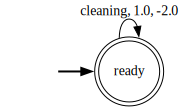

In [17]:
def cleaning_human_service(name: str = CLEANING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human cleaning device."""
    return build_generic_service_one_state(
        name,
        {CLEANING},
        action_reward=action_reward
    )


service_cleaning_human = cleaning_human_service()
render_service(service_cleaning_human)


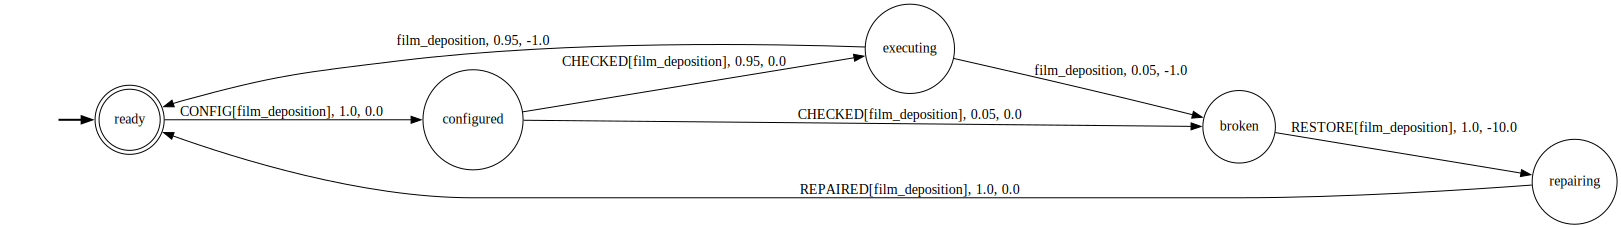

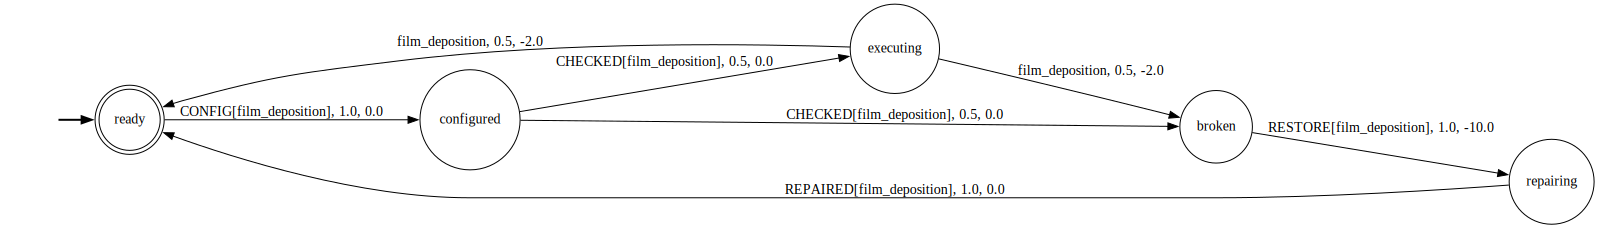

In [18]:
def film_deposition_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                            action_reward: float) -> Service:
    """Build the film deposition device."""
    return build_complex_breakable_service(name, FILM_DEPOSITION, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_film_deposition1 = film_deposition_service(FILM_DEPOSITION1_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                   DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_film_deposition2 = film_deposition_service(FILM_DEPOSITION2_SERVICE_NAME, BROKEN_PROB, HIGH_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_film_deposition1)
render_service(service_film_deposition2)

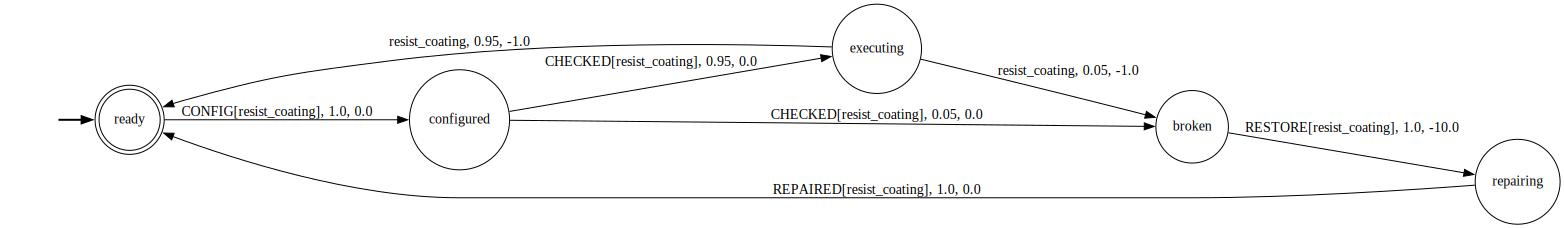

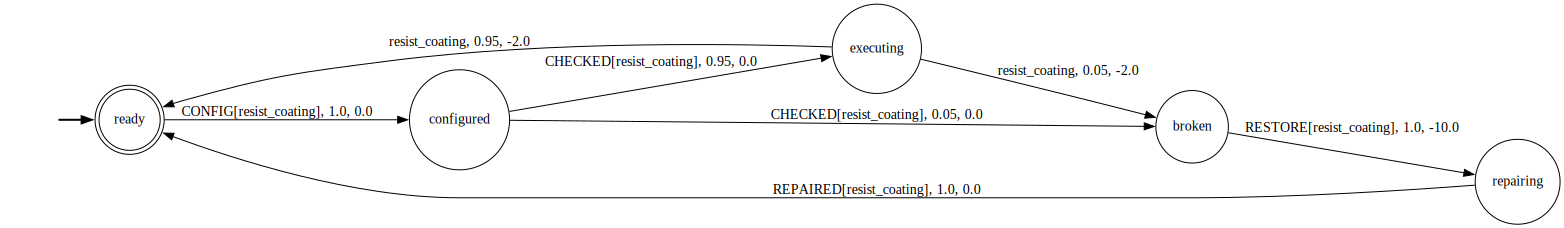

In [19]:
def resist_coating_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                           action_reward: float) -> Service:
    """Build the resist coating device."""
    return build_complex_breakable_service(name, RESIST_COATING, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_resist_coating1 = resist_coating_service(RESIST_COATING1_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                 DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_resist_coating2 = resist_coating_service(RESIST_COATING2_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                 DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_resist_coating1)
render_service(service_resist_coating2)

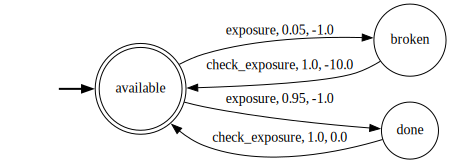

In [20]:
def exposure_service(name: str = EXPOSURE_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                     broken_reward: float = DEFAULT_BROKEN_REWARD,
                     action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the exposure device."""
    return build_generic_breakable_service(name, EXPOSURE, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_exposure = exposure_service()
render_service(service_exposure)

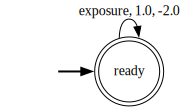

In [21]:
def exposure_human_service(name: str = EXPOSURE_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human exposure device."""
    return build_generic_service_one_state(
        name,
        {EXPOSURE},
        action_reward=action_reward
    )


service_exposure_human = exposure_human_service()
render_service(service_exposure_human)

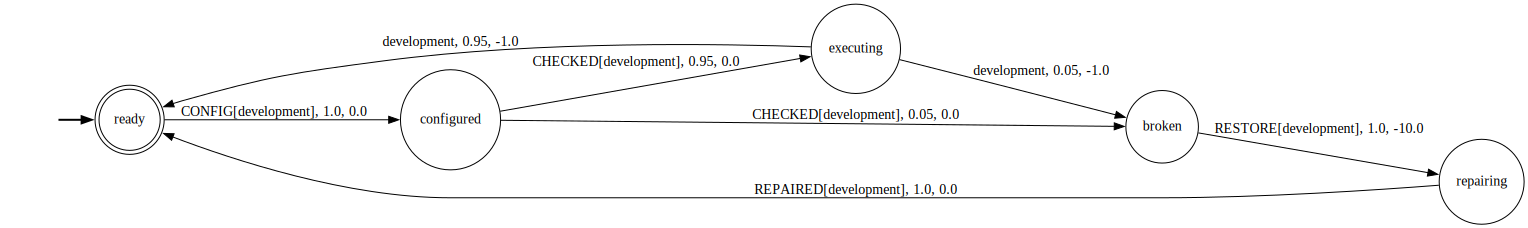

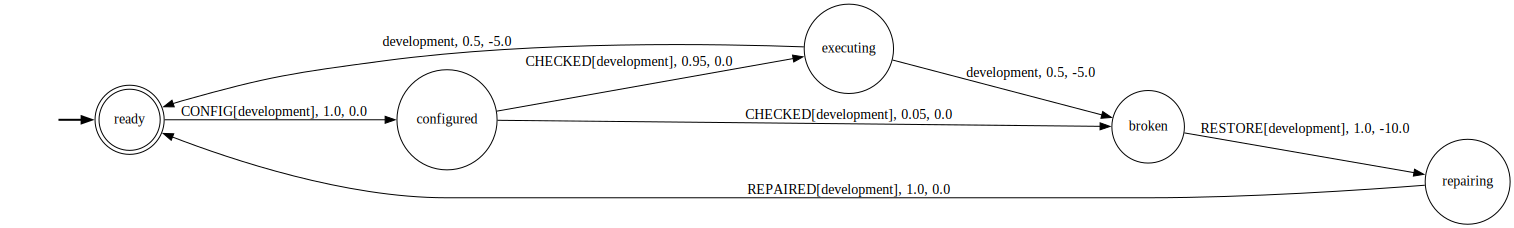

In [22]:
def development_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                        action_reward: float) -> Service:
    """Build the development device."""
    return build_complex_breakable_service(name, DEVELOPMENT, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_development1 = development_service(DEVELOPMENT1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                           DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_development2 = development_service(DEVELOPMENT2_SERVICE_NAME, BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                           DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_development1)
render_service(service_development2)


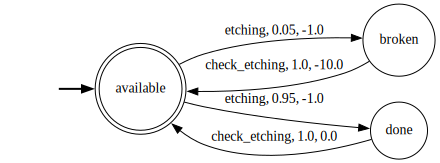

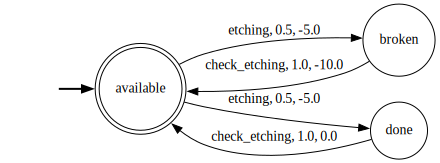

In [23]:
def etching_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the etching device."""
    return build_generic_breakable_service(name, ETCHING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_etching1 = etching_service(ETCHING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD,
                                   DEFAULT_USA_REWARD)
service_etching2 = etching_service(ETCHING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_etching1)
render_service(service_etching2)


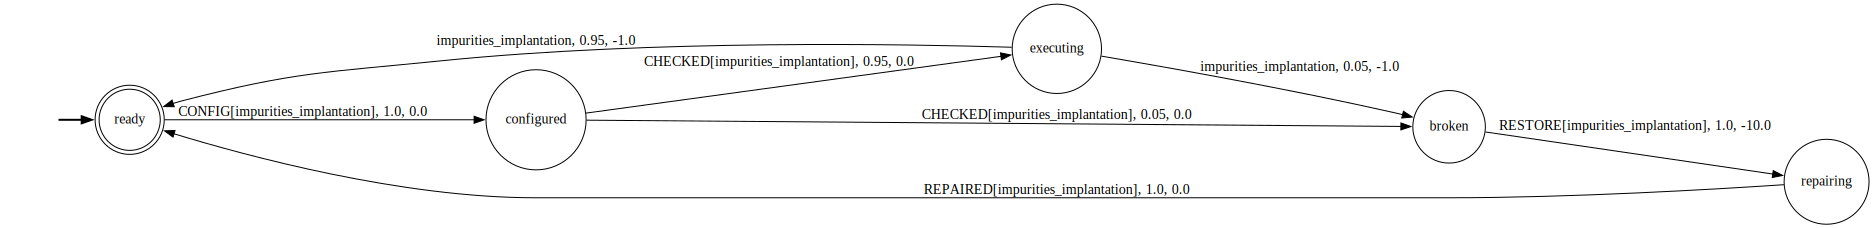

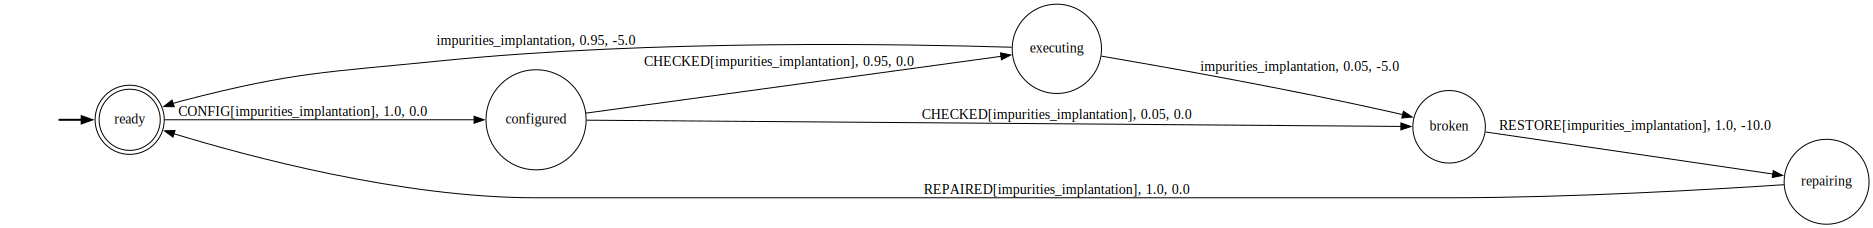

In [24]:
def impurities_implantation_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                                    action_reward: float) -> Service:
    """Build the impurities implantation device."""
    return build_complex_breakable_service(name, IMPURITIES_IMPLANTATION, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_impurities_implantation1 = impurities_implantation_service(IMPURITIES_IMPLANTATION1_SERVICE_NAME,
                                                                   DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                                                   DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_impurities_implantation2 = impurities_implantation_service(IMPURITIES_IMPLANTATION2_SERVICE_NAME,
                                                                   DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                                                   DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_impurities_implantation1)
render_service(service_impurities_implantation2)


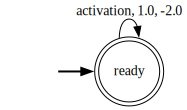

In [25]:
def activation_human_service(name: str = ACTIVATION_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human activation device."""
    return build_generic_service_one_state(
        name,
        {ACTIVATION},
        action_reward=action_reward
    )


service_activation_human = activation_human_service()
render_service(service_activation_human)


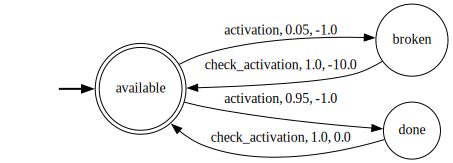

In [26]:
def activation_service(name: str = ACTIVATION_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                       broken_reward: float = DEFAULT_BROKEN_REWARD,
                       action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the activation device."""
    return build_generic_breakable_service(name, ACTIVATION, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_activation = activation_service()
render_service(service_activation)

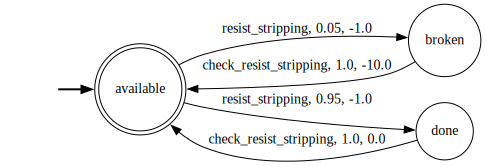

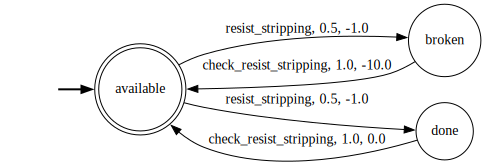

In [27]:
def resist_stripping_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the resist stripping device."""
    return build_generic_breakable_service(name, RESIST_STRIPPING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_resist_stripping1 = resist_stripping_service(RESIST_STRIPPING1_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                     DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_resist_stripping2 = resist_stripping_service(RESIST_STRIPPING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD,
                                                     DEFAULT_USA_REWARD)
render_service(service_resist_stripping1)
render_service(service_resist_stripping2)

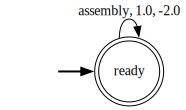

In [28]:
def assembly_human_service(name: str = ASSEMBLY_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human assembly device."""
    return build_generic_service_one_state(
        name,
        {ASSEMBLY},
        action_reward=action_reward
    )


service_assembly_human = assembly_human_service()
render_service(service_assembly_human)


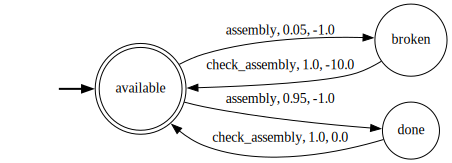

In [29]:
def assembly_service(name: str = ASSEMBLY_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                     broken_reward: float = DEFAULT_BROKEN_REWARD,
                     action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the assembly device."""
    return build_generic_breakable_service(name, ASSEMBLY, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_assembly = assembly_service()
render_service(service_assembly)


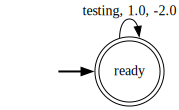

In [30]:
def testing_human_service(name: str = TESTING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human testing device."""
    return build_generic_service_one_state(
        name,
        {TESTING},
        action_reward=action_reward
    )


service_testing_human = testing_human_service()
render_service(service_testing_human)


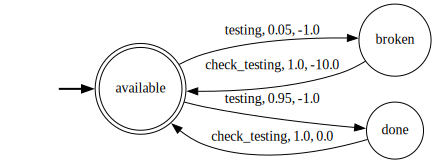

In [31]:
def testing_service(name: str = TESTING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                    broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the testing device."""
    return build_generic_breakable_service(name, TESTING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_testing = testing_service()
render_service(service_testing)

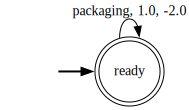

In [32]:
def packaging_human_service(name: str = PACKAGING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human packaging device."""
    return build_generic_service_one_state(
        name,
        {PACKAGING},
        action_reward=action_reward
    )


service_packaging_human = packaging_human_service()
render_service(service_packaging_human)

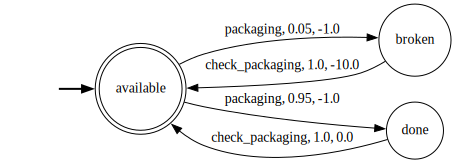

In [33]:
def packaging_service(name: str = PACKAGING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                      broken_reward: float = DEFAULT_BROKEN_REWARD,
                      action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the packaging device."""
    return build_generic_breakable_service(name, PACKAGING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_packaging = packaging_service()
render_service(service_packaging)

# First Phase - Raw materials and design assortment
## Target Specification
The target specification of the first phase is defined as follows:

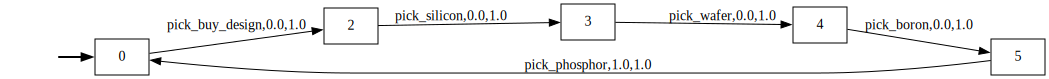

In [34]:
formula_str = "<"
regex_seq = ""
for symbol_index, symbol in enumerate(SYMBOLS_PHASE_1):
    all_but_symbol = set(SYMBOLS_PHASE_1).difference({symbol})
    item = symbol + "&" + " & ".join(map(lambda x: "!" + x, all_but_symbol))
    regex_seq = regex_seq + (";" if symbol_index != 0 else "") + item
formula_str = f"<({regex_seq})*>end"
formula = pylogics.parsers.ldl.parse_ldl(formula_str)
automaton = logaut.core.ldl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, set(SYMBOLS_PHASE_1))
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)


## Composition MDP
The Composition MDP is constructed in this way:

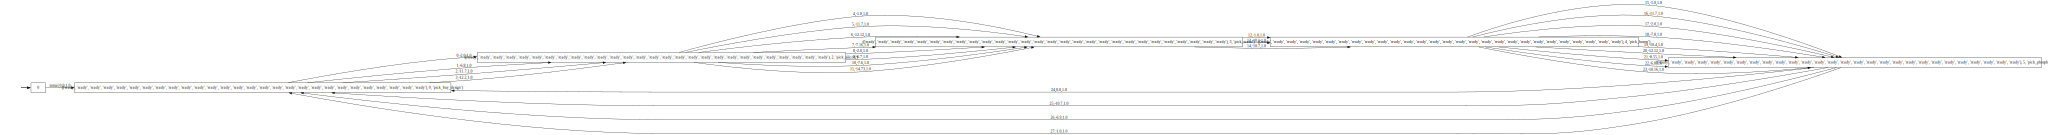

In [38]:
all_services = [
    # 0
    design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD),
    # 1
    design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD),
    # 2
    design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 3
    design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD),
    # 4
    silicon_warehouse_service(SILICON_WAREHOUSE_SERVICE_NAME, DEFAULT_USA_REWARD),
    # 5
    silicon_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 6
    silicon_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD),
    # 7
    silicon_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD),
    # 8
    silicon_service(SILICON_SERVICE_NAME_USA, USA_REWARD),
    # 9
    silicon_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD),
    # 10
    silicon_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD),
    # 11
    silicon_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD),
    # 12
    wafer_warehouse_service(WAFER_WAREHOUSE_SERVICE_NAME, DEFAULT_USA_REWARD),
    # 13
    wafer_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD),
    # 14
    wafer_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA),
    # 15
    boron_warehouse_service(BORON_WAREHOUSE_SERVICE_NAME, DEFAULT_USA_REWARD),
    # 16
    boron_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 17
    boron_service(BORON_SERVICE_NAME_USA, USA_REWARD),
    # 18
    boron_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD),
    # 19
    boron_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD),
    # 20
    boron_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD),
    # 21
    boron_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD),
    # 22
    boron_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD),
    # 23
    boron_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD),
    # 24
    phosphor_warehouse_service(PHOSPHOR_WAREHOUSE_SERVICE_NAME, DEFAULT_USA_REWARD),
    # 25
    phosphor_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 26
    phosphor_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD),
    # 27
    phosphor_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD)
]
trimmed_declare_automaton = declare_automaton.trim()
stochastic_target = target_from_dfa(trimmed_declare_automaton)
#mdp = comp_mdp(declare_automaton, all_services, gamma=0.9)
mdp = composition_mdp(stochastic_target, *all_services, gamma=0.9)
render_composition_mdp(mdp)

# Optimal policy
Calculation of optimal policy:

In [41]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)


In [43]:
print_policy_data(opt_policy)

Policy:
State=0,	Action=initial
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0, 'pick_buy_design'),	Action=0
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 2, 'pick_silicon'),	Action=4
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 3, 'pick_wafer'),	Action=12
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'

# Value Function
Calculation of Value Function:

In [44]:
print_value_function(value_function)

Value function:
State=0,	value=-9.755805719030064
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 4, 'pick_boron'),	value=-9.780225147127059
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0, 'pick_buy_design'),	value=-10.839784132255627
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5, 'pick_phosphor'),	value=-9.755805719030064
State=(('ready', 'ready', 're

In [45]:
print_q_value_function(q_value_function)

Q-value function:
State=0:
	Action=initial,	Value=-9.755805719030064

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0, 'pick_buy_design'):
	Action=0,	Value=-10.839784132255627
	Action=1,	Value=-15.639784132255627
	Action=2,	Value=-20.539784132255626
	Action=3,	Value=-21.039784132255626

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 2, 'pick_silicon'):
	Action=4,	Value=-9.821982369172918
	Action=5,	Value=-20.521982369172918
	Action=6,	Value=-20.94198236917292
	Action=7,	Value=-15.981982369172918
	Action=8,	Value=-10.821982369172918
	Action=9,	Value=-15.521982369172

# Second phase - Manufacturing Process
## Target Specification
The target specification of the second phase is structured as follows:


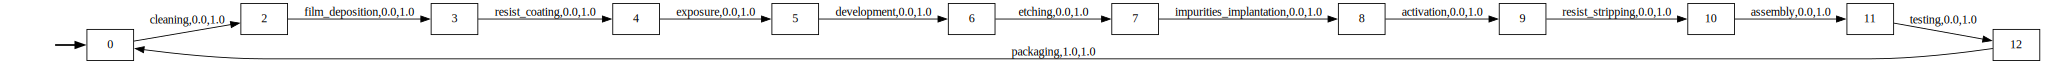

In [48]:
formula_str = "<"
regex_seq = ""
for symbol_index, symbol in enumerate(SYMBOLS_PHASE_2):
    all_but_symbol = set(SYMBOLS_PHASE_1).difference({symbol})
    item = symbol + "&" + " & ".join(map(lambda x: "!" + x, all_but_symbol))
    regex_seq = regex_seq + (";" if symbol_index != 0 else "") + item
formula_str = f"<({regex_seq})*>end"
formula = pylogics.parsers.ldl.parse_ldl(formula_str)
automaton = logaut.core.ldl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, set(SYMBOLS_PHASE_2))
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

In [ ]:
all_services = [
    # 0
    cleaning_service(CLEANING_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 1
    cleaning_human_service(CLEANING_HUMAN_SERVICE_NAME, USA_REWARD),
    # 2
    film_deposition_service(FILM_DEPOSITION1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 3
    film_deposition_service(FILM_DEPOSITION2_SERVICE_NAME, BROKEN_PROB, HIGH_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD),
    # 4
    resist_coating_service(RESIST_COATING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 5
    resist_coating_service(RESIST_COATING2_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD),
    # 6
    exposure_service(EXPOSURE_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 7
    exposure_human_service(EXPOSURE_HUMAN_SERVICE_NAME, USA_REWARD),
    # 8
    development_service(DEVELOPMENT1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 9
    development_service(DEVELOPMENT2_SERVICE_NAME, BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD),
    # 10
    etching_service(ETCHING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 11
    etching_service(ETCHING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD),
    # 12
    impurities_implantation_service(IMPURITIES_IMPLANTATION1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 13
    impurities_implantation_service(IMPURITIES_IMPLANTATION2_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD),
    # 14
    activation_human_service(ASSEMBLY_HUMAN_SERVICE_NAME, USA_REWARD),
    # 15
    activation_service(ASSEMBLY_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 16
    resist_stripping_service(RESIST_STRIPPING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 17
    resist_stripping_service(RESIST_STRIPPING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 18
    assembly_human_service(ASSEMBLY_HUMAN_SERVICE_NAME, USA_REWARD),
    # 19
    assembly_service(ASSEMBLY_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 20
    testing_human_service(ASSEMBLY_HUMAN_SERVICE_NAME, USA_REWARD),
    # 21
    testing_service(ASSEMBLY_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 22
    packaging_human_service(ASSEMBLY_HUMAN_SERVICE_NAME, USA_REWARD),
    # 23
    packaging_service(ASSEMBLY_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
]
trimmed_declare_automaton = declare_automaton.trim()
stochastic_target = target_from_dfa(trimmed_declare_automaton)
#mdp = comp_mdp(declare_automaton, all_services, gamma=0.9)
mdp = composition_mdp(stochastic_target, *all_services, gamma=0.9)
render_composition_mdp(mdp)

# Optimal policy
Calculation of optimal policy:

In [ ]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

In [ ]:
print_policy_data(opt_policy)

# Value Function
Calculation of Value Function:

In [ ]:
print_value_function(value_function)

In [ ]:
print_q_value_function(q_value_function)